In [1]:
import re
from pathlib import Path

from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

import torch


def parse_file(file_path):
    iterations = []
    ratios = []
    fgt_acc1 = []
    fgt_acc5 = []
    test_acc1 = []
    test_acc5 = []
    MIA = []
    celeb_top1 = []
    celeb_top5 = []

    with open(file_path, 'r') as file:
        for line in file:
            iter_match = re.search(r'iter: (\d+)', line)
            ratio_match = re.search(r'ratio: ([\d\-.]+)', line)
            fgt_acc1_match = re.search(r'fgt_acc@1: ([\d.]+)%', line)
            fgt_acc5_match = re.search(r'fgt_acc@5: ([\d.]+)%', line)
            test_acc1_match = re.search(r'test_acc@1: ([\d.]+)%', line)
            test_acc5_match = re.search(r'test_acc@5: ([\d.]+)%', line)
            MIA_match = re.search(r'MIA: ([\d.]+)±([\d.]+)', line)
            celeb_top1_match = re.search(r'celeb top1: ([\d.]+)', line)
            celeb_top5_match = re.search(r'celeb top5: ([\d.]+)', line)

            if iter_match:
                iterations.append(int(iter_match.group(1)))
            if ratio_match:
                ratios.append(float(ratio_match.group(1)))
            if fgt_acc1_match:
                fgt_acc1.append(float(fgt_acc1_match.group(1)))
            if fgt_acc5_match:
                fgt_acc5.append(float(fgt_acc5_match.group(1)))
            if test_acc1_match:
                test_acc1.append(float(test_acc1_match.group(1)))
            if test_acc5_match:
                test_acc5.append(float(test_acc5_match.group(1)))
            if MIA_match:
                MIA.append((float(MIA_match.group(1)), float(MIA_match.group(2))))
            if celeb_top1_match:
                celeb_top1.append(float(celeb_top1_match.group(1)))
            if celeb_top5_match:
                celeb_top5.append(float(celeb_top5_match.group(1)))

    return {
        'iterations': sorted(list(set(iterations))),
        'ratios': sorted(list(set(ratios)), reverse=True),
        'fgt_acc1': fgt_acc1,
        'fgt_acc5': fgt_acc5,
        'test_acc1': test_acc1,
        'test_acc5': test_acc5,
        'MIA': MIA,
        'celeb_top1': celeb_top1,
        'celeb_top5': celeb_top5
    }


In [9]:
celeb_name = "Elon_Musk"
# celeb_name = "Taylor_Swift"

# pair = "ViT-B-32 laion400m_e32"
pair = "convnext_base laion400m_s13b_b51k"
model_name, ckpt = pair.split(' ')
part = 'vision'
layer_name = "visual.proj"
layer_name = "visual.transformer.resblocks.11.mlp.c_fc.weight"
layer_name = "visual.transformer.resblocks.11.attn.out_proj.weight"
layer_name = "visual.transformer.resblocks.5.mlp.c_fc.weight"
# layer_name = "visual.transformer.resblocks.7.attn.out_proj.weight"
# layer_name = "visual.transformer.resblocks.6.attn.out_proj.weight"

# convnext_base
# layer_name = 'visual.trunk.stem.0.weight'
# layer_name = 'visual.trunk.stages.0.blocks.0.conv_dw.weight' 
layer_name = 'visual.trunk.stages.2.blocks.17.conv_dw.weight' 
layer_name = 'visual.trunk.stages.3.blocks.0.mlp.fc2.weight'

part = 'language'
layer_name = "text_projection"
layer_name = "transformer.resblocks.0.attn.out_proj.weight"
layer_name = 'transformer.resblocks.10.attn.out_proj.weight'
layer_name = 'transformer.resblocks.11.attn.out_proj.weight'
# layer_name = 'transformer.resblocks.7.attn.out_proj.weight'
# convnext_base


save_root = Path(f'figs/output_linear/{celeb_name}/{model_name}-{part}-{layer_name}')

# part = 'whole'
# save_root = Path(f'figs/output_linear/{celeb_name}/{model_name}-{part}')


txt_path = save_root / 'log.txt'
results = parse_file(txt_path)

In [3]:
# results
# results['fgt_acc1']

ValueError: x and y must have same first dimension, but have shapes (91,) and (90,)

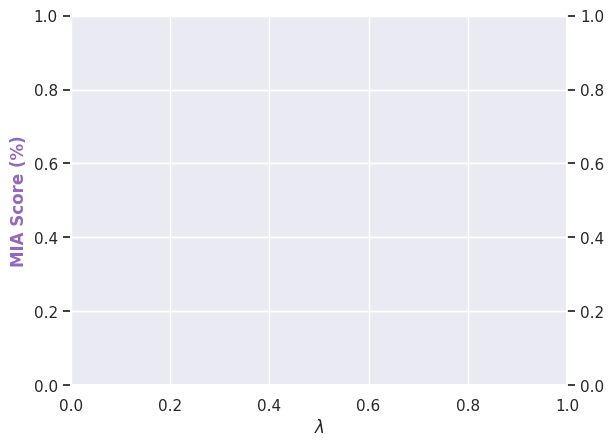

In [10]:
# different scales
linewidth = 2

n = 100

mia_avg = [item[0] for item in results['MIA']]
mia_std = [item[1] for item in results['MIA']]
# x = list(range(len(avg_MIA_cos_forget_test_list)))[:n]
x = np.abs(results['ratios'][:n])

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax1.set_xlabel(r'$\lambda$', fontweight="bold")
color = 'tab:purple'
ax1.set_ylabel('MIA Score (%)', color=color, fontweight="bold")  # we already handled the x-label with ax1
ax1.plot(x, mia_avg[:n], color=color, linestyle='dashed', linewidth=linewidth)
ax1.grid(False)

ax2.set_ylabel('Accuracy (%)', fontweight="bold")
ax2.plot(x, results['fgt_acc1'][:n], label='Forget Acc@1', linewidth=linewidth)
ax2.plot(x, results['fgt_acc5'][:n], label='Forget Acc@5', linewidth=linewidth)
ax2.plot(x, results['celeb_top1'][:n], label='Celeb100 Acc@1', linewidth=linewidth)
# plt.plot(x, results['celeb_top5'][:n], label='Celeb100 Acc@5')
ax2.plot(x, results['test_acc1'][:n], label='Test Acc@1', linewidth=linewidth)
# ax1.set_ylim([-5,100])
# plt.plot(x, results['test_acc5'][:n])
ax2.grid(False)


# ax2.legend(loc='lower right')
ax2.legend()
# plt.legend(loc='lower right')
plt.tight_layout()
if part == 'whole':
    save_path = Path(f'figs/output_linear/{celeb_name}/{model_name}-{part}.png')
    plt.savefig(save_path)
    save_path = Path(f'figs/output_linear/{celeb_name}/{model_name}-{part}.pdf')
    plt.savefig(save_path)
else:
    save_path = f'figs/output_linear/{celeb_name}/{model_name}-{part}-{layer_name}.png'
    plt.savefig(save_path)
    save_path = f'figs/output_linear/{celeb_name}/{model_name}-{part}-{layer_name}.pdf'
    plt.savefig(save_path)
plt.show()

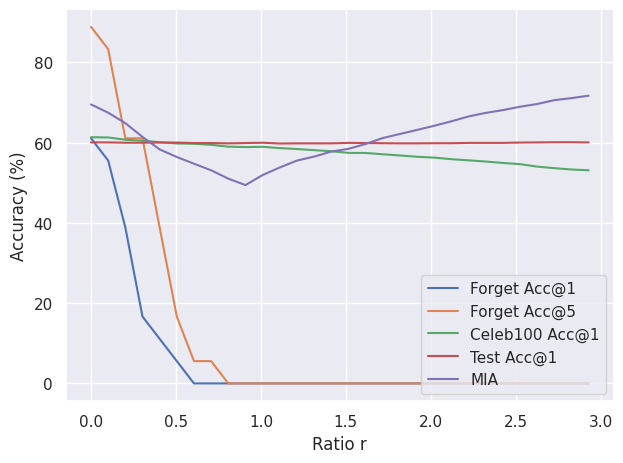

In [49]:
n = 30

mia_avg = [item[0] for item in results['MIA']]
mia_std = [item[1] for item in results['MIA']]
# x = list(range(len(avg_MIA_cos_forget_test_list)))[:n]
x = np.abs(results['ratios'][:n])
plt.plot(x, results['fgt_acc1'][:n], label='Forget Acc@1')
plt.plot(x, results['fgt_acc5'][:n], label='Forget Acc@5')
plt.plot(x, results['celeb_top1'][:n], label='Celeb100 Acc@1')
# plt.plot(x, results['celeb_top5'][:n], label='Celeb100 Acc@5')
plt.plot(x, results['test_acc1'][:n], label='Test Acc@1')
# plt.plot(x, results['test_acc5'][:n])
plt.plot(x, mia_avg[:n], label='MIA')

# plt.plot(x, avg_MIA_cos_forget_test_list[:n])
# # plt.plot(x, avg_MIA_cos_train_test_list[:n])
# plt.plot(x, [item*100 for item in forget_acc1_list][:n])
# plt.plot(x, [item*100 for item in forget_acc5_list][:n])
# plt.plot(x, [item*100 for item in test_top1_list][:n])
# plt.plot(x, [item*100 for item in test_top5_list][:n])
# plt.plot(x, MIA_cos_forget_test_list)

plt.ylabel('Accuracy (%)')
plt.xlabel('Ratio r')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [30]:
# len(results['ratios'])
mia_avg = [item[0] for item in results['MIA']]
mia_std = [item[1] for item in results['MIA']]
mia_avg, mia_std

([69.54,
  65.86,
  60.8,
  56.51,
  53.2,
  49.91,
  46.2,
  56.2,
  58.53,
  60.43,
  62.15,
  64.44,
  66.77,
  68.35,
  69.87,
  71.56,
  72.72,
  73.82,
  74.84,
  75.99,
  76.78,
  77.44,
  78.03,
  78.42,
  79.06,
  79.74,
  80.14,
  80.55,
  81.06,
  81.7,
  82.17,
  82.69,
  83.02,
  83.28,
  83.54,
  83.81,
  84.12,
  84.39,
  84.66,
  84.92,
  85.36,
  85.64,
  85.82,
  86.07,
  86.25,
  86.4,
  86.68,
  86.86,
  86.97,
  87.17,
  87.39,
  87.69,
  87.84,
  87.98,
  88.1,
  88.3,
  88.42,
  88.54,
  88.69,
  88.83,
  88.95,
  89.09,
  89.16,
  89.24,
  89.32,
  89.41,
  89.46,
  89.48,
  89.56,
  89.63,
  89.69,
  89.75,
  89.78,
  89.77,
  89.8,
  89.87,
  89.93,
  90.0,
  90.02,
  90.08,
  90.13,
  90.19,
  90.22,
  90.24,
  90.28,
  90.32,
  90.38,
  90.43,
  90.54,
  90.61,
  90.67,
  90.7,
  90.7,
  90.74,
  90.77,
  90.8,
  90.86,
  90.88,
  90.91,
  90.92],
 [0.36,
  0.47,
  0.64,
  0.78,
  0.92,
  0.92,
  0.87,
  1.06,
  0.98,
  0.92,
  0.97,
  0.95,
  1.05,
  1.17,


## Curves for comparison

In [28]:
import re
from pathlib import Path

from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

import torch

def parse_file_2(file_path):
    iterations = []
    ratios = []
    fgt_acc1 = []
    fgt_acc5 = []
    test_acc1 = []
    test_acc5 = []
    MIA = []
    celeb_top1 = []
    celeb_top5 = []

    # Pattern to extract information
    # pattern = re.compile(
    #     r"Eval Epoch: (\d+) "
    #     r"imagenet-zeroshot-val-top1: ([\d.]+)\t"
    #     r"imagenet-zeroshot-val-top5: ([\d.]+)\t"
    #     r"Forget acc Elon_Musk top1: ([\d.]+), top5: ([\d.]+)\t"
    #     r"Celeb100 top1: ([\d.]+), top5: ([\d.]+)\t"
    #     r"MIA loss: ([\d.]+)±([\d.]+), MIA dsit: ([\d.]+)±([\d.]+)\t"
    #     r"time: ([\d.]+)"
    # )

    
    # pattern = re.compile(
    #     r"iter: (\d+),"
    #     r"fgt_acc@1: ([\d.]+),"
    #     r"fgt_acc@5: ([\d.]+),"
    #     r"celeba100@1: ([\d.]+),"
    #     r"celeba100@5: ([\d.]+),"
    #     r"test_acc@1: ([\d.]+),"
    #     r"test_acc@5: ([\d.]+),"
    #     r"MIA: ([\d.]+)±([\d.]+),"
    #     r"time: ([\d.]+)"
    # )
    
    # with open(file_path, 'r') as file:
    #     for line in file:
    #         match = pattern.search(line)
    #         if match:
    #             iterations.append(int(match.group(1)))
    #             fgt_acc1.append(float(match.group(4)))
    #             fgt_acc5.append(float(match.group(5)))
    #             test_acc1.append(float(match.group(2)))
    #             test_acc5.append(float(match.group(3)))
    #             MIA.append((float(match.group(10)), float(match.group(11))))
    #             celeb_top1.append(float(match.group(6)))
    #             celeb_top5.append(float(match.group(7)))


    pattern = r'iter: (\d+), fgt_acc@1: ([\d\.]+), fgt_acc@5: ([\d\.]+), celeba100@1: ([\d\.]+), celeba100@5: ([\d\.]+), test_acc@1: ([\d\.]+), test_acc@5: ([\d\.]+), MIA: ([\d\.]+)±([\d\.]+), time: ([\d\.]+)'
    with open(file_path, 'r') as file:
        for line in file:
            match = re.search(pattern, line)
            if match:
                iterations.append(int(match.groups()[0]))
                fgt_acc1.append(float(match.groups()[1]))
                fgt_acc5.append(float(match.groups()[2]))
                test_acc1.append(float(match.groups()[5]))
                test_acc5.append(float(match.groups()[6]))
                MIA.append((float(match.groups()[7]), float(match.groups()[8])))
                celeb_top1.append(float(match.groups()[3]))
                celeb_top5.append(float(match.groups()[4]))
            else:
                print("No match found")

    return {
        'iterations': sorted(list(set(iterations))),
        # 'ratios': sorted(list(set(ratios)), reverse=True),
        'fgt_acc1': fgt_acc1,
        'fgt_acc5': fgt_acc5,
        'test_acc1': test_acc1,
        'test_acc5': test_acc5,
        'MIA': MIA,
        'celeb_top1': celeb_top1,
        'celeb_top5': celeb_top5
    }


def calculate_averages(data_list):
    # Initialize a dictionary to hold the sum of each field
    sums = {}
    # Initialize the result dictionary for averages
    averages = {}
    
    # Process each item in the list
    for data in data_list:
        for key, value in data.items():
            # Handle numeric values
            if isinstance(value, (int, float)):
                if key in sums:
                    sums[key] += value
                else:
                    sums[key] = value
            # Handle tuple values (for example 'MIA')
            elif isinstance(value, tuple) and all(isinstance(num, (int, float)) for num in value):
                if key not in sums:
                    sums[key] = tuple(0 for _ in value)
                sums[key] = tuple(sum(x) for x in zip(sums[key], value))
    
    # Calculate averages
    num_items = len(data_list)
    for key, sum_value in sums.items():
        if isinstance(sum_value, tuple):
            averages[key] = tuple(x / num_items for x in sum_value)
        else:
            averages[key] = sum_value / num_items
    
    return averages

In [53]:
# txt_path = 'ckpt/log_2024_06_26-09_28_42_ViT-B-32_Elon_Musk_ssd.txt'

# salun
# txt_path = 'ckpt/log_2024_06_25-19_41_46_ViT-B-32_Elon_Musk_salun_lr1e-07.txt'
# salun_o
txt_path = 'ckpt/log_2024_06_26-16_37_44_ViT-B-32_Elon_Musk_salun_lr1e-06.txt'
# ssd
txt_path = 'ckpt/log_2024_06_26-16_59_03_ViT-B-32_Elon_Musk_ssd.txt'

# ft
txt_path = 'ckpt/log_2024_06_26-17_32_36_ViT-B-32_Elon_Musk_ft_lr1e-06.txt'
# ga
txt_path = 'ckpt/log_2024_06_26-18_31_58_ViT-B-32_Elon_Musk_ga_o_lr1e-06.txt'
# gaft
txt_path = 'ckpt/log_2024_06_26-23_35_22_ViT-B-32_Elon_Musk_gaft_o_lr1e-06.txt'


# results = parse_file(txt_path)
results = parse_file_2(txt_path)

print(results)

{'iterations': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'fgt_acc1': [0.9444444444444444, 1.0, 0.7777777777777778, 0.1111111111111111, 0.05555555555555555, 0.0, 0.05555555555555555, 0.05555555555555555, 0.05555555555555555, 0.05555555555555555], 'fgt_acc5': [1.0, 1.0, 0.8333333333333334, 0.1111111111111111, 0.1111111111111111, 0.0, 0.05555555555555555, 0.05555555555555555, 0.05555555555555555, 0.05555555555555555], 'test_acc1': [0.6004, 0.5852, 0.556, 0.528, 0.4776, 0.3988, 0.3652, 0.292, 0.1884, 0.1152], 'test_acc5': [0.85, 0.84, 0.8196, 0.7968, 0.7448, 0.6388, 0.5952, 0.4992, 0.3716, 0.2656], 'MIA': [(58.31, 0.72), (73.48, 1.24), (89.53, 0.64), (94.67, 0.59), (94.05, 0.52), (94.49, 0.52), (95.33, 0.48), (95.79, 0.45), (95.86, 0.47), (96.05, 0.46)], 'celeb_top1': [0.5846996255119322, 0.5609774081505535, 0.5179658365764713, 0.424434862785488, 0.19558768784784925, 0.012082919254658384, 0.012360317460317459, 0.00765079365079365, 0.0010317460317460316, 0.0010317460317460316], 'celeb_top5': [0.80055

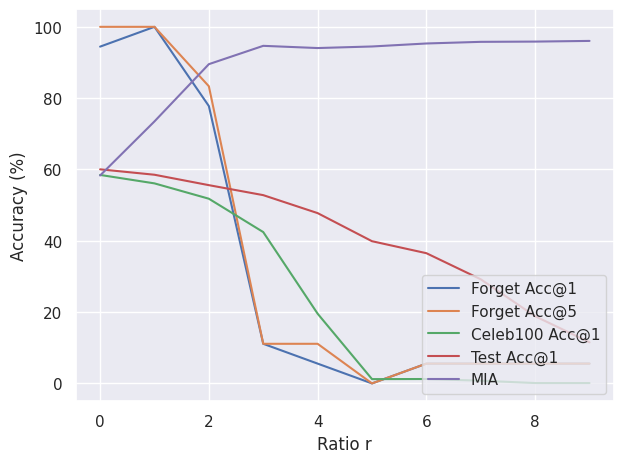

In [54]:
n = 30

mia_avg = [item[0] for item in results['MIA']]
mia_std = [item[1] for item in results['MIA']]
results['test_acc1'] = [item*100 for item in results['test_acc1']]
results['fgt_acc1'] = [item*100 for item in results['fgt_acc1']]
results['fgt_acc5'] = [item*100 for item in results['fgt_acc5']]
results['celeb_top1'] = [item*100 for item in results['celeb_top1']]


# x = list(range(len(avg_MIA_cos_forget_test_list)))[:n]
x = np.abs(results['iterations'][:n])
plt.plot(x, results['fgt_acc1'][:n], label='Forget Acc@1')
plt.plot(x, results['fgt_acc5'][:n], label='Forget Acc@5')
plt.plot(x, results['celeb_top1'][:n], label='Celeb100 Acc@1')
# plt.plot(x, results['celeb_top5'][:n], label='Celeb100 Acc@5')
plt.plot(x, results['test_acc1'][:n], label='Test Acc@1')
# plt.plot(x, results['test_acc5'][:n])
plt.plot(x, mia_avg[:n], label='MIA')

# plt.plot(x, avg_MIA_cos_forget_test_list[:n])
# # plt.plot(x, avg_MIA_cos_train_test_list[:n])
# plt.plot(x, [item*100 for item in forget_acc1_list][:n])
# plt.plot(x, [item*100 for item in forget_acc5_list][:n])
# plt.plot(x, [item*100 for item in test_top1_list][:n])
# plt.plot(x, [item*100 for item in test_top5_list][:n])
# plt.plot(x, MIA_cos_forget_test_list)

plt.ylabel('Accuracy (%)')
plt.xlabel('Ratio r')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
# salun_o
txt_path = 'ckpt/log_2024_06_26-16_37_44_ViT-B-32_Elon_Musk_salun_lr1e-06.txt'
# ssd
txt_path = 'ckpt/log_2024_06_26-16_59_03_ViT-B-32_Elon_Musk_ssd.txt'

# ft
txt_path = 'ckpt/log_2024_06_26-17_32_36_ViT-B-32_Elon_Musk_ft_lr1e-06.txt'
# ga
txt_path = 'ckpt/log_2024_06_26-18_31_58_ViT-B-32_Elon_Musk_ga_o_lr1e-06.txt'
# gaft
txt_path = 'ckpt/log_2024_06_26-23_35_22_ViT-B-32_Elon_Musk_gaft_o_lr1e-06.txt'

In [81]:
# salun
folder_root = Path('ckpt')
# files = folder_root.glob("log_2024_06_2*_salun_lr1e-06.txt")
# files = folder_root.glob("log_2024_06_2*_ft_lr1e-06.txt")
# files = folder_root.glob("log_2024_06_2*_ga_lr1e-06.txt")
# files = folder_root.glob("log_2024_06_2*_ga_o_lr1e-06.txt")
# files = folder_root.glob("log_2024_06_2*_gaft_lr1e-06.txt")
# files = folder_root.glob("log_2024_06_2*_gaft_o_lr1e-06.txt")
files = folder_root.glob("log_2024_06_2*_ssd.txt")
data_list = []
# for file in sorted(list(files)):
# for file in sorted(list(files))[1:]:
# for file in sorted(list(files))[2:]:
for file in sorted(list(files))[4:]:
    print(file)
    results = parse_file_2(file)
    # print(results)

    # Find the first zero or the lowest fgt_acc1
    first_zero_index = None
    min_value = float('inf')
    min_index = None
    
    for i, acc in enumerate(results['fgt_acc1']):
        if acc == 0 and first_zero_index is None:
            first_zero_index = i
            break
        if acc < min_value:
            min_value = acc
            min_index = i
    
    # Use first zero if available, otherwise use the index of the minimum value
    target_index = first_zero_index if first_zero_index is not None else min_index
    
    # Output the data at the found index
    output = {key: values[target_index] for key, values in results.items()}
    data_list.append(output)
    # print(output)

averages = calculate_averages(data_list)

ckpt/log_2024_06_26-16_59_03_ViT-B-32_Elon_Musk_ssd.txt


In [30]:
# salun
averages

{'iterations': 4.25,
 'fgt_acc1': 0.1625,
 'fgt_acc5': 0.19583333333333333,
 'test_acc1': 0.48619999999999997,
 'test_acc5': 0.7429000000000001,
 'MIA': (92.55250000000001, 0.49000000000000005),
 'celeb_top1': 0.1860989733760368,
 'celeb_top5': 0.29622179939215987}

In [82]:
# ssd
averages

{'iterations': 0.0,
 'fgt_acc1': 0.0,
 'fgt_acc5': 0.0,
 'test_acc1': 0.002,
 'test_acc5': 0.0048,
 'MIA': (58.42, 0.91),
 'celeb_top1': 0.0008,
 'celeb_top5': 0.02}

In [36]:
# ft
averages

{'iterations': 2.4,
 'fgt_acc1': 0.6916507936507936,
 'fgt_acc5': 0.9015238095238095,
 'test_acc1': 0.6036,
 'test_acc5': 0.85368,
 'MIA': (72.92399999999999, 0.8960000000000001),
 'celeb_top1': 0.606289218982402,
 'celeb_top5': 0.8149402227972535}

In [44]:
# ga
averages

{'iterations': 0.0,
 'fgt_acc1': 0.0,
 'fgt_acc5': 0.0,
 'test_acc1': 0.4391,
 'test_acc5': 0.6295,
 'MIA': (87.4525, 0.6124999999999999),
 'celeb_top1': 0.31154966105505877,
 'celeb_top5': 0.47843603560524806}

In [48]:
# ga_o
averages

{'iterations': 5.0,
 'fgt_acc1': 0.36746031746031743,
 'fgt_acc5': 0.3841269841269841,
 'test_acc1': 0.21133333333333335,
 'test_acc5': 0.33,
 'MIA': (89.42999999999999, 0.5966666666666667),
 'celeb_top1': 0.1648579449115292,
 'celeb_top5': 0.2484974316885982}

In [46]:
# gaft
averages

{'iterations': 0.0,
 'fgt_acc1': 0.0,
 'fgt_acc5': 0.0,
 'test_acc1': 0.5561333333333333,
 'test_acc5': 0.8145333333333333,
 'MIA': (89.76, 0.58),
 'celeb_top1': 0.2825761630513713,
 'celeb_top5': 0.45130693153089857}

In [50]:
# gaft_o
averages

{'iterations': 5.0,
 'fgt_acc1': 0.5007936507936508,
 'fgt_acc5': 0.5007936507936508,
 'test_acc1': 0.3446666666666667,
 'test_acc5': 0.5884,
 'MIA': (94.41666666666667, 0.24333333333333332),
 'celeb_top1': 0.05647620055127749,
 'celeb_top5': 0.10353816474739302}

In [80]:
# ours
# def find_best_iteration(filename):
#     # Variables to keep track of the best iteration
#     best_iter = None
#     best_ratio = None
#     highest_test_acc = float('-inf')
    
#     # Open and read the file
#     with open(filename, 'r') as file:
#         for line in file:
#             # Parse the line
#             parts = line.split(',')
#             iteration = int(parts[0].split(':')[-1].strip())
#             ratio = float(parts[1].split(':')[-1].strip())
#             fgt_acc = float(parts[2].split(':')[-1].strip())
#             test_acc = float(parts[3].split(':')[-1].strip())
            
#             # Check if fgt_acc is 0 and test_acc is higher than the current highest
#             if fgt_acc == 0 and test_acc > highest_test_acc:
#                 highest_test_acc = test_acc
#                 best_iter = iteration
#                 best_ratio = ratio
    
#     return best_iter, highest_test_acc, best_ratio

def find_optimal_iteration(filename):
    # Variables to keep track of the best iteration
    best_iter = None
    lowest_fgt_acc = float('inf')
    highest_test_acc = float('-inf')
    
    # First pass to find the lowest fgt_acc
    with open(filename, 'r') as file:
        for line in file:
            parts = line.split(',')
            fgt_acc = float(parts[2].split(':')[-1].strip())
            if fgt_acc < lowest_fgt_acc:
                lowest_fgt_acc = fgt_acc
    
    # Second pass to find the highest test_acc among the lowest fgt_acc
    with open(filename, 'r') as file:
        for line in file:
            parts = line.split(',')
            iteration = int(parts[0].split(':')[-1].strip())
            ratio = float(parts[1].split(':')[-1].strip())
            fgt_acc = float(parts[2].split(':')[-1].strip())
            test_acc = float(parts[3].split(':')[-1].strip())
            
            # Check if current line's fgt_acc matches the lowest and if its test_acc is higher than the highest found
            if fgt_acc == lowest_fgt_acc and test_acc > highest_test_acc:
                highest_test_acc = test_acc
                best_iter = iteration
                best_ratio = ratio
    
    return best_iter, lowest_fgt_acc, highest_test_acc, best_ratio
    
fgt_acc_list = []
test_acc_list = []
output_root = Path("figs/output")
for celeb_folder in list(output_root.iterdir()):
    for layer_folder in list(celeb_folder.iterdir()):
        if not layer_folder.is_dir() or 'ViT' not in str(layer_folder) or '1.attn.out_proj.weight' in str(layer_folder) or '1.mlp.c_proj.weight' in str(layer_folder):
            continue
        # log_txt
        log_txt_path = layer_folder/'log.txt'
        best_iter, lowest_fgt_acc, highest_test_acc, best_ratio = find_optimal_iteration(log_txt_path)
        # print(layer_folder, best_iter, lowest_fgt_acc, highest_test_acc, best_ratio)
        print(best_iter, lowest_fgt_acc, highest_test_acc, best_ratio)
        fgt_acc_list.append(lowest_fgt_acc)
        test_acc_list.append(highest_test_acc)
        
        
print(np.mean(fgt_acc_list), np.mean(test_acc_list))


10 0.0 0.6008 -0.08513751871491308
5 0.0 0.5908 -6.509902317227479
7 0.0 0.6 -1.4103449172848102
1 0.0 0.6012 -4.603327998614797
6 0.0 0.5988 -0.05160048721639418
1 0.0 0.6012 -0.8645351322911049
2 0.0 0.6028 -2.0387736749970196
3 0.0 0.6016 -0.0655951058089976
4 0.0 0.6012 -0.23208779002129082
3 0.0 0.6016 -0.08711776787177813
2 0.0 0.6024 -2.6004955091735877
4 0.0 0.5956 -7.844837921309452
6 0.0 0.5984 -0.551192720774679
1 0.0 0.6012 -8.398494798696358
1 0.0 0.6024 -0.7886567583695916
5 0.0 0.6008 -0.045227019318176825
6 0.0 0.5996 -0.05310001471417277
2 0.0 0.6028 -3.8162937504348777
3 0.0 0.6024 -1.786653937203376
4 0.0 0.6032 -0.4829334399903307
8 0.0 0.598 -0.07087012173568144
1 0.0 0.6028 -5.16377394776174
4 0.0 0.5976 -0.25881937501090146
1 0.0 0.5996 -1.620189449030402
7 0.0 0.5972 -0.7289221681129704
5 0.0 0.6012 -0.12357692618708664
3 0.0 0.5992 -0.09579243741285132
2 0.0 0.6008 -1.927809219681767
1 0.0 0.6008 -0.9688244225755881
5 0.0 0.6008 -2.629458656373062
9 0.0 0.5924 

False